# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


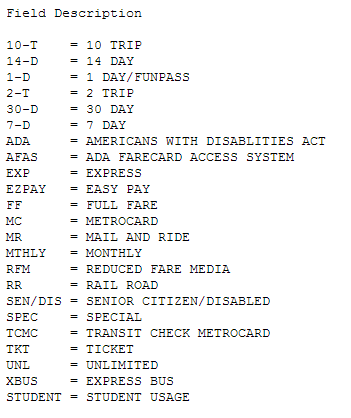

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as pl
from IPython.display import clear_output

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above`

In [2]:
# Import the data
mta = np.load("MTA_Fare.npy") 

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [5]:
# define date range
start = pd.datetime(2010,5,26)
arr_dateRange = pd.date_range(start = start, periods = 194, freq = '7D')

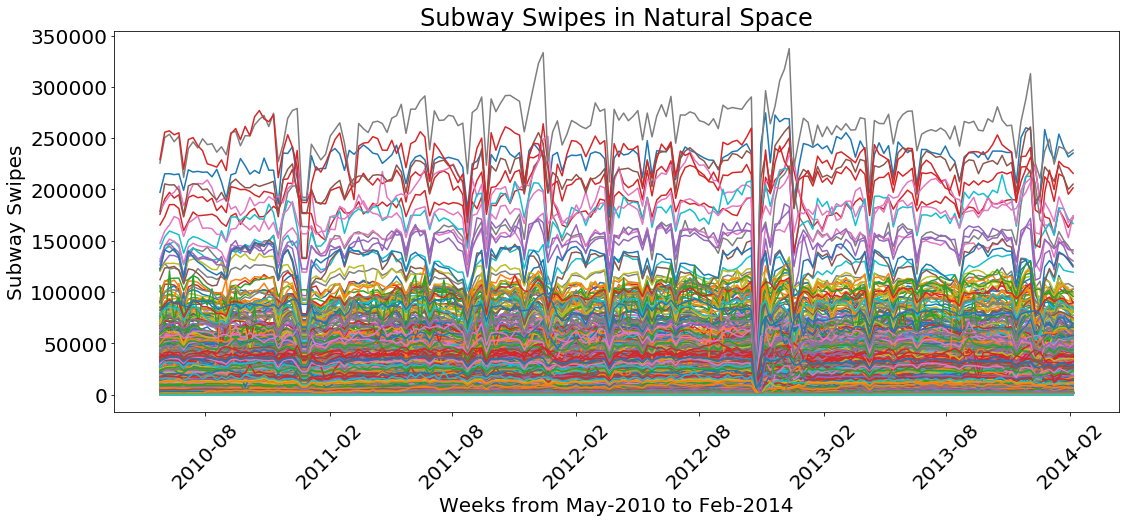

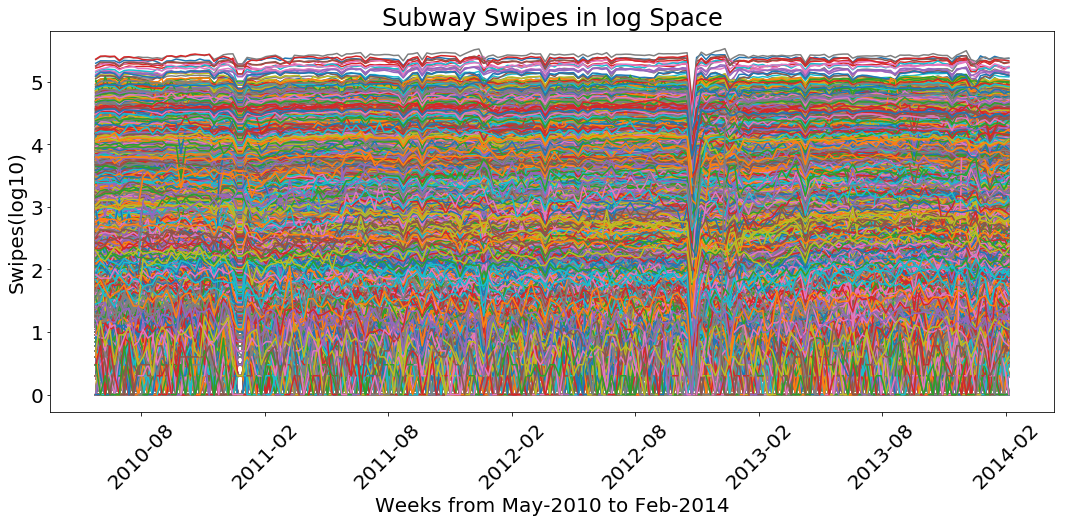

In [6]:
# Plot the time series in natural space
plt.subplots(figsize = (18,7))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(arr_dateRange, mta[i][j], '-')
plt.xlabel("Weeks from May-2010 to Feb-2014")
plt.xticks(rotation=45)
plt.ylabel("Subway Swipes")
plt.title("Subway Swipes in Natural Space")
plt.show()

print("    ")

# Plot the time series in log space
plt.subplots(figsize = (18,7))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(arr_dateRange, np.log10(mta[i][j]), '-')
plt.xlabel("Weeks from May-2010 to Feb-2014")
plt.xticks(rotation=45)
plt.ylabel("Swipes(log10)")
plt.title("Subway Swipes in log Space")
plt.show()

#### Figure 1: Subway swipes in natural and log space.

1. The top figure show the time series of subway swipes in natural space for 23 card types for all the 600 stations.
2. The top figure show the time series of subway swipes in log space for 23 card types for all the 600 stations.
3. Although, it is difficult to make any inference from this plot, some dates shows drop in ridership across each time series. 

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [ ]:
# Standard scale each time series; Find the positional argument with max abs(z-score) for each time series

# Define an empty list
lis = []
scaler = StandardScaler()
# run a loop for each time series
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        arr = mta[i][j]
        # Standardize each time series
        scaler.fit(arr)
        # Append the position with maximum abs value into list
        lis.append(np.abs(scaler.transform(arr)).argmax())
clear_output()

In [12]:
# remove position argument 0; as many timeseries has missing value and hence positonal argument 0 
lis1 = [x for x in lis if x!=0 ]
# print the date with maximum number of occurences
arr_dateRange[pd.Series(pd.Series(lis1).value_counts()).idxmax(axis = 1)]

Timestamp('2012-10-24 00:00:00', offset='7D')

### The week of 17-Oct-2012 to 24-Oct-2012 has most prominent event.

1. In this week hurricane sandy hit NYC.
2. Due to hurricance Sandy there was a huge disruption in transportation services.
3. This disruption can be seen in MTA too as there is a dip in most of the times series for this week.


 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [13]:
# Mean over card type to get 23 timeseries
mtaCard = mta.mean(axis=0)

In [14]:
# Find the rolling means
df_mtaCard = pd.DataFrame(mtaCard)
df_rollingMean = df_mtaCard.rolling(window=3, center=True ,axis=1).mean()

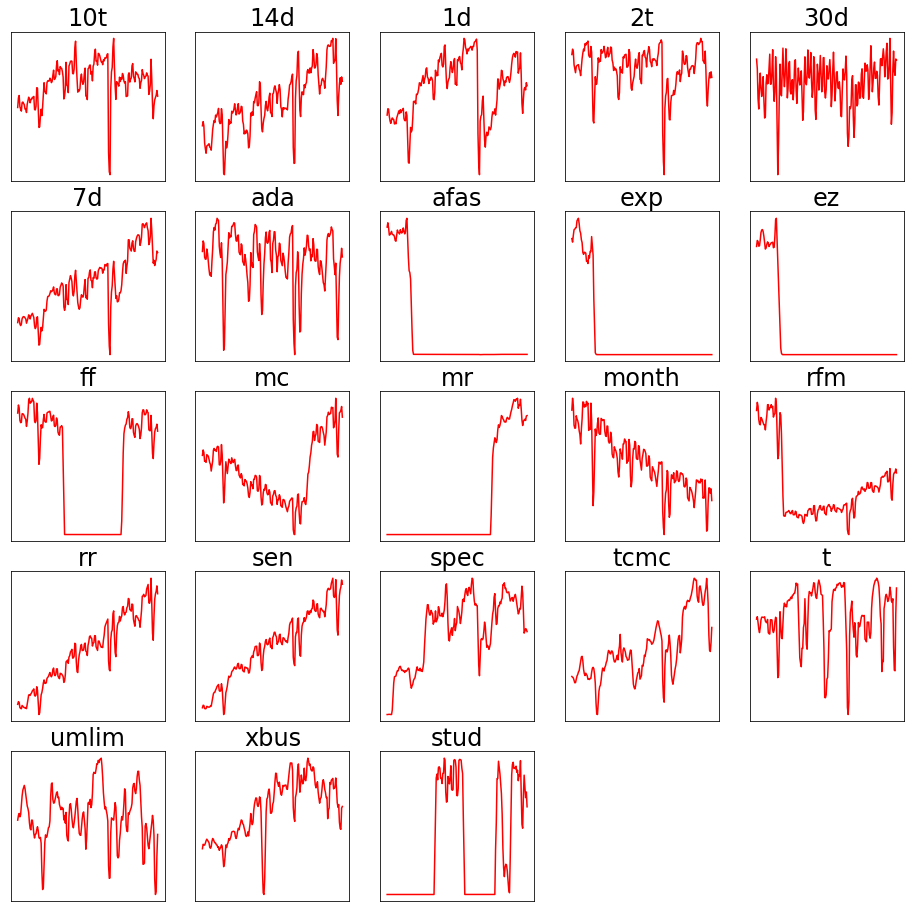

In [17]:
# Visualize each time series
plt.figure(figsize=(16,16))
for i in df_rollingMean.index:
    plt.subplot(5,5,i+1)
    plt.plot(range(194), df_rollingMean.loc[i,:],'r-')
    plt.title(ridetype[i])
    plt.xticks([])
    plt.yticks([])

#### Patterns of Rolling Mean for each card type

1. x- axis represent week number; y-axis rolling mean
2. Some card type have regular pattern ex: 14d month rr
3. Some card types show change in structure ex: stud ff mr

In [18]:
# Ridership Ratio beginning/end:  
df_ratioRidership = pd.DataFrame(data = {'Card':ridetype, 'ratioRidership': df_rollingMean[1] / df_rollingMean[192] })
df_ratioRidership = df_ratioRidership[df_ratioRidership['ratioRidership']>0]

Increasing:  sen
Decreasing:  month


([], <a list of 0 Text xticklabel objects>)

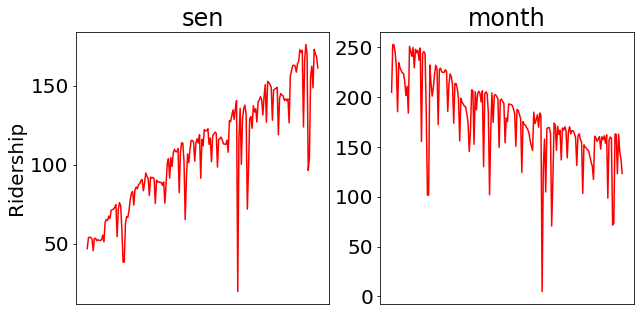

In [19]:
# Increasing and Decreasing card types
print("Increasing: ", df_ratioRidership.Card[df_ratioRidership['ratioRidership'].idxmin()])
print("Decreasing: ", df_ratioRidership.Card[df_ratioRidership['ratioRidership'].idxmax()])

# Visualize each time series
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(194), df_mtaCard.loc[df_ratioRidership['ratioRidership'].idxmin(),:],'r-')
plt.title(ridetype[df_ratioRidership['ratioRidership'].idxmin()])
plt.ylabel("Ridership")
plt.xticks([])

plt.subplot(1,2,2)
plt.plot(range(194), df_mtaCard.loc[df_ratioRidership['ratioRidership'].idxmax(),:],'r-')
plt.title(ridetype[df_ratioRidership['ratioRidership'].idxmax()])
#plt.ylabel("Ridership")
plt.xticks([])


#### Fig: Time series pattern of: [ Increasing Card Type: SEN ; Decreasing Card Type: MONTH ]

1. SEN is most increasing type of card with miniumum beginning/end ratio.
2. Month is most decreasing type of card with maximum beginning/end ratio.
3. Both the time series pattern are consistent visually

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [20]:
columns = []
for i in range(194):
    columns.append(i)
columns.append('Station')
columns.append('label')

In [23]:
# Prepare data frame with all time series and card as labels
df_cardTimeSeries = pd.DataFrame(columns = columns)
index = 0
for i in range(mta.shape[0]):
    print(np.round((index/13800)*100,2),"% Done")
    for j in range(mta.shape[1]):
        df_cardTimeSeries.loc[index,0:194] = mta[i][j]
        df_cardTimeSeries.loc[index,'label'] = j
        df_cardTimeSeries.loc[index,'Station'] = i
        index = index + 1
    clear_output()
        

In [24]:
# mean for each stations
stationsmeans = mta.mean(axis=(1,2))
print(stationsmeans.shape)
df_stationsmeans = pd.DataFrame({'Station': range(600), 'StationMean': stationsmeans})
df_cardTimeSeries = df_cardTimeSeries.merge(df_stationsmeans, on = 'Station', how = "inner")

(600,)


In [25]:
# std for each stations
stationsstd = mta.std(axis=(1,2))
print(stationsstd.shape)
df_stationsstd = pd.DataFrame({'Station': range(600), 'StationStd': stationsstd})
df_cardTimeSeries = df_cardTimeSeries.merge(df_stationsstd, on = 'Station', how = "inner")

(600,)


In [26]:
# mean and std for each time series
df_cardTimeSeries['MeanTimeSeries']=df_cardTimeSeries.iloc[:,0:194].mean(axis=1)
df_cardTimeSeries['StdTimeSeries']=df_cardTimeSeries.iloc[:,0:194].std(axis=1)

In [27]:
# remove time series with missing values
df_cardTimeSeries = df_cardTimeSeries[df_cardTimeSeries['StdTimeSeries']>0]
len(df_cardTimeSeries)

9317

In [28]:
# reset index
df_cardTimeSeries.reset_index(inplace=True, drop=True)

In [29]:
# Normed Time Series Mean & Std
df_cardTimeSeries['normed_time_series_mean'] = df_cardTimeSeries['MeanTimeSeries']/df_cardTimeSeries['StationMean']
df_cardTimeSeries['normed_time_series_std'] = df_cardTimeSeries['StdTimeSeries']/df_cardTimeSeries['StationStd']
df_cardTimeSeries['normed_time_series_std'].head()

0    1.325220
1    0.038465
2    0.005009
3    0.014269
4    0.010185
Name: normed_time_series_std, dtype: float64

In [30]:
# Normalize the time series
df_cardTimeSeriesNorm = pd.DataFrame(columns= range(194))
for i in range(194):
    df_cardTimeSeriesNorm.loc[:,i] = (df_cardTimeSeries.loc[:,i]- df_cardTimeSeries['MeanTimeSeries'])/df_cardTimeSeries['StdTimeSeries']

Text(0,0.5,'standardized number of rides')

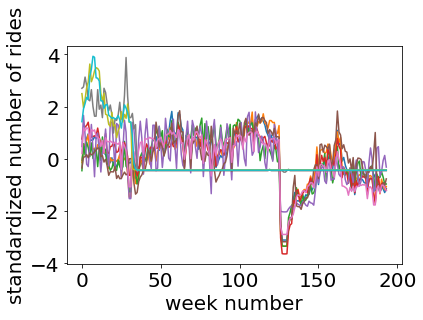

In [31]:
# Plot first 10 time series
for i in range(10):
    plt.plot(range(194),df_cardTimeSeriesNorm.iloc[i,:])
plt.xlabel("week number")
pl.ylabel("standardized number of rides")

#### Figure: Plot of first 10 Normalized Time Series Pattern

In [32]:
# Make sm models which fit line through each time series
allfits = [sm.OLS(np.array(df_cardTimeSeries.iloc[x,0:194]),sm.add_constant(range(194))).fit() for x in df_cardTimeSeries.index]
[a.params[0] for a in allfits[:10]]

[71890.84869151459,
 2091.2375892149084,
 282.7639968279141,
 915.9172085646314,
 407.48564631245046,
 21297.249484536092,
 41997.96748612209,
 29.473909595559086,
 3439.0558287073736,
 1505.7963521015063]

In [1]:
allfits

NameError: name 'allfits' is not defined

## Build a model that uses the built features as input features(4 features) :

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [35]:
# Create train test split
X_train, X_test, y_train, y_test0 = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              df_cardTimeSeries['normed_time_series_mean'], df_cardTimeSeries['normed_time_series_std']]).T, 
    df_cardTimeSeries['label'].values, test_size=0.33, random_state=42)

In [36]:
# Shapes of created train test split
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test0).shape

((6242, 4), (3075, 4), (6242,), (3075,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

X_train[~np.isfinite(X_train)] =  ... make a choice about what to do with this datapoint. drop it or replace it with something

In [39]:
# initiate Random forest classifier, fit and predict 
clf0 = rfc()
clf0.fit(X_train,list(y_train))
y_pred0 = clf0.predict(X_test)

and use sklearn confusion_matrix to see the errors

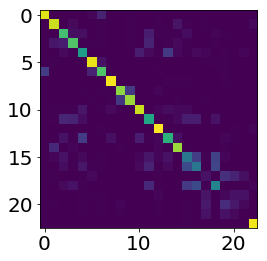

In [40]:
# The confusion matrix
imshow(confusion_matrix(list(y_test0), y_pred0))

#### Fig: Confusion Matrix for Random forest built with 4 features on the test set.
1. The Diagonal represents the correct classifications; Region apart from diagonal represent wrong classifications.
2. Yellow means high count.
3. For most of the cards the majorly correct classification is done.
4. For cards after number 15, the classification is not good and is shown by dispersed value on diagonal.

 and use classification_report to assess the model

In [41]:
# Classification report
print(classification_report(list(y_test0), y_pred0, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.84      0.88      0.86       160
        14d       0.80      0.87      0.83       157
         1d       0.65      0.74      0.69       141
         2t       0.74      0.70      0.72       154
        30d       0.56      0.58      0.57       142
         7d       0.86      0.93      0.89       154
        ada       0.76      0.72      0.74       149
       afas       0.92      0.97      0.95       150
        exp       0.81      0.80      0.81       153
         ez       0.81      0.82      0.81       154
         ff       0.82      0.81      0.82       168
         mc       0.55      0.55      0.55       157
         mr       0.87      0.97      0.92       152
      month       0.67      0.60      0.63       159
        rfm       0.80      0.83      0.82       151
         rr       0.40      0.38      0.39       151
        sen       0.44      0.36      0.39       162
       spec       0.18      0.13      0.15   

#### Results: Classification report for performance of random forest model built with 4 features over the test set.

1. Overall F1 Score of 0.70 is good.
2. Best Card Results:
    1. 'Stud' with 0.97 F1 Score. precision and recall are all high.
    2. Others are 'Afas' 'Mr' with F1 better than 0.9.  
    3. If we go back and check the rolling mean plot these cards had consistenet time series.
3. Worst Card Results:
    1. 'Spec' and 'Xbus'
    2. They had shift in structure in the rolling mean plots.

clf.feature_importances_ to find the important features

In [43]:
clf0.feature_importances_

array([ 0.18834106,  0.23903654,  0.33608651,  0.23653589])

#### Results: Feature Importances for performance of random forest model built with 4 features over the test set.

1. The most important feature is normed time series Mean.
2. The least important feature is intercept of the fitted line over time series.

## Build a model that uses as input features each time stamp (194 features) :


In [46]:
# use the same split ratio
X_train, X_test, y_train, y_test1 = train_test_split( np.array(df_cardTimeSeriesNorm), df_cardTimeSeries['label'].values, 
                                                    test_size=0.33, random_state=42)

In [48]:
# initiate Random forest classifier, fit and predict 
clf1 = rfc()
clf1.fit(X_train,list(y_train))
y_pred1 = clf1.predict(X_test)

and use sklearn confusion_matrix to see the errors

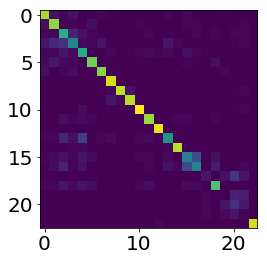

In [49]:
# The confusion matrix
imshow(confusion_matrix(list(y_test1), y_pred1))

#### Fig: Confusion Matrix for Performance of Random forest built with 194 features on the test set.
1. The Diagonal represents the correct classifications; Region apart from diagonal represent wrong classifications.
2. Yellow means high count.
3. For most of the cards the majorly correct classification is done.
4. 'tcmc' card which has number higher than 15 has shown a drastic improvement in acc. It is represented by the green dot in bottom right corner of the plot

 and use classification_report to assess the model

In [50]:
# Classification report
print(classification_report(list(y_test1), y_pred1, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.77      0.84      0.80       160
        14d       0.70      0.82      0.76       157
         1d       0.50      0.69      0.58       141
         2t       0.56      0.46      0.51       154
        30d       0.55      0.68      0.61       142
         7d       0.80      0.79      0.79       154
        ada       0.89      0.85      0.87       149
       afas       0.86      0.97      0.91       150
        exp       0.98      0.92      0.95       153
         ez       0.93      0.90      0.92       154
         ff       0.89      0.92      0.90       168
         mc       0.82      0.84      0.83       157
         mr       0.96      0.99      0.97       152
      month       0.73      0.52      0.61       159
        rfm       0.94      0.92      0.93       151
         rr       0.54      0.44      0.49       151
        sen       0.59      0.44      0.50       162
       spec       0.50      0.17      0.25   

#### Results: Classification report for performance of random forest model built with 194 features over the test set.

1. Overall F1 Score of 0.74 is good. Better than the model before.
2. Best Card Results:
    1. 'Stud' with 0.99 F1 Score. precision and recall are all high. Better than the model before.
    2. Others F1 better than 0.9: 'Afas' 'Mr' with new entries 'Rfm' 'ez' 'ff' 'exp' 
    3. 'tcmc'has shown a drastic gain in F1 model in this new model compared to before
3. Worst Card Results:
    1. 'Spec' and 'Xbus'
4. Overall with increase in number of features the performances have improved

and clf.feature_importances_ to find the important features

In [55]:
print("Max Important Feature: " ,clf1.feature_importances_.argmax())
print("Min Important Feature: " ,clf1.feature_importances_.argmin())
clf1.feature_importances_

Max Important Feature:  126
Min Important Feature:  96


array([ 0.00283716,  0.00361796,  0.0085369 ,  0.00412096,  0.00345399,
        0.00451254,  0.004636  ,  0.00344296,  0.00663756,  0.00207337,
        0.00313336,  0.00673411,  0.00285782,  0.0035248 ,  0.01180938,
        0.00771271,  0.00321972,  0.00499179,  0.00771211,  0.00530626,
        0.00687041,  0.00385884,  0.00321342,  0.01618326,  0.00760179,
        0.01629422,  0.00384071,  0.00599492,  0.00788357,  0.00890635,
        0.00421555,  0.00733006,  0.01319825,  0.01210745,  0.01370206,
        0.01021868,  0.0050971 ,  0.00168362,  0.00731838,  0.00282317,
        0.00371037,  0.0031452 ,  0.00704799,  0.00386036,  0.00596756,
        0.00323448,  0.00451222,  0.00694474,  0.00533137,  0.00469399,
        0.00601876,  0.00373727,  0.00518035,  0.00285356,  0.00237218,
        0.00224595,  0.00252315,  0.00449192,  0.00155379,  0.00167237,
        0.00347803,  0.00215938,  0.00266794,  0.00509081,  0.00279014,
        0.00750821,  0.00358022,  0.00154892,  0.00591031,  0.01

#### Results: Feature Importances for performance of random forest model built with 194 features over the test set.

1. The most important feature is 126. Apparently the same week when Sandy Hurricane striked NYC.
2. The least important feature is 96.